In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Image:    
    # Image object, manupulation and overlay
    def __init__(self, filename):
        matrix = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)
        self.matrix = matrix > 0
        # Load image to B TF array
        self.cols, self.rows = self.matrix.shape
        self.around = np.asarray([[int(i) for i in j] for j in np.zeros((self.rows, self.cols))])
        # Emrpty array to calculate sides around
        self.overlay = np.zeros((self.rows, self.cols)) > 0
        # Empty array for overlay TF array
   
    def getAroundsum(self, point):
        # Calculate sum of sides in + direction
        x, y = point
        '''
        around = [ (x-1, y-1), (x-1, y), (x-1, y+1),
                   (x, y-1),   (x, y),   (x, y+1),
                   (x+1, y-1), (x+1, y), (x+1, y+1) ]
        '''
        around_x = [(x, y-1),             (x, y+1),]
        around_y = [(x-1, y),             (x+1, y),]
        axis = lambda axes : sum([int(self.matrix[i]) for i in axes])
        # Calculating sum in | direction annd _ direction
        # return sum |, sum _, center +
        return axis(around_x), axis(around_y), self.matrix[x][y]

    def genOverlay(self):
        # Gnerate overlay as boolean matrix of same shape
        for i in range(1, self.rows-1):
            for j in range(1, self.cols-1):
                # if surrounded by 2 true block then false
                if sum(self.getAroundsum((i, j))) != 3:
                    self.overlay[i][j] = True   
                # if in L shape, then True
                elif self.getAroundsum((i, j)) == (1, 1, 1):
                    self.overlay[i][j] = True 
                # if centre is false then no overlay there
                if self.getAroundsum((i, j))[2] != 1:
                    self.overlay[i][j] = False
                    
        for i in range(self.cols):
            # if outer edge then false except entry and exit
            if self.matrix[0][i] == True: self.overlay[0][i] = True
            if self.matrix[-1][i] == True: self.overlay[-1][i] = True
    
    def overlayPoints(self):
        # so where are the overlay points? generate cartesian list
        self.listOrdinates = []
        for i in range(self.rows):
            for j in range(self.cols):
                if self.overlay[i][j] == 1: 
                    self.listOrdinates.append((i, j))
        return self.listOrdinates
    
    def displayOverlay(self):
        # display overlay over the image
        mat1, mat2 = self.matrix.astype(int) ,self.overlay.astype(int)
        # mat1: original matrix, mat2: overlay matrix
        overlayresult = mat2
        # result void matrix
        for i in range(self.rows):
            for j in range(self.cols):
                if mat1[i][j] == 1 and mat2[i][j] == 0:
                    # Yellow for non-overlay
                    overlayresult[i][j] = 256
                elif mat1[i][j] == 1 and mat2[i][j] == 1:
                    # Blue for overlay
                    overlayresult[i][j] = 128
                else:
                    # Purple for rest
                    overlayresult[i][j] = 0
        # display the overlay result
        plt.imshow(overlayresult)

In [3]:
class Node:
    # Node analysis and check intermediate
    def __init__(self, ordinate, link, image):
        # initialize node
        self.locn = ordinate
        self.input_node = []
        self.mAtrix = image.matrix
        # attributes locn, input_node, mAtrix
        self.location(link)
        # find direction of position
        
    def add_nodes(self, link):
        # add anther node
        self.location(link)
    
    def location(self, link):
        x2, y2, x1, y1 = self.locn[0], self.locn[1], link[0], link[1]
        if x1 - x2 == 0:
            if y1 - y2 > 0: orientation = 'R'
            elif y1 - y2 < 0: orientation = 'L'          
        elif y1 - y2 == 0:
            if x1 - x2 > 0: orientation = 'D'
            elif x1 - x2 < 0: orientation = 'U'            
            else: pass
        else: return None
        # added_point, distance2point, direction
        distance = int(((x1 - x2)**2 + (y1 - y2)**2)**0.5)
        self.input_node.append( ((x1, y1), distance, orientation) )
    
    def filterOrientation(self):
        # filter to get minimum of all the sides
        inf = ((0, 0), float("inf"))
        minDict = {'R' :inf, 'L' :inf, 'D' :inf, 'U' :inf}
        
        for i, j, k in self.input_node:
            if minDict[k][1] > j:
                minDict[k] = (i, j)
        # append only minimum to the input_node
        self.input_node = [(value[0], value[1], key)for key, value in minDict.items() if value[1] != inf[1]]
            
    def checkOverlayObstruction(self):
        x1, y1 = self.locn
        
        for extreme in self.input_node:
            # for all direction of least in + direction
               
            if extreme[2] == 'L':
                # if it lies in same line along Y-axis
                for i in range(y1, extreme[0][1], 1):
                    if self.mAtrix[x1][i] == False:
                        self.input_node.remove(extreme)
                        break
            
            if extreme[2] == 'R':
                # if it lies in same line along Y-axis
                for i in range(y1, extreme[0][1], -1):
                    if self.mAtrix[x1][i] == False:
                        self.input_node.remove(extreme)
                        break
                        
            if extreme[2] == 'U':
                # if it lies in same line along X-axis
                for i in range(x1, extreme[0][0], 1):
                    if self.mAtrix[i][y1] == False:
                        self.input_node.remove(extreme)
                        break
            
            if extreme[2] == 'D':
                # if it lies in same line along X-axis
                for i in range(x1, extreme[0][0], -1):
                    if self.mAtrix[i][y1] == False:
                        self.input_node.remove(extreme)
                        break
    
    def genNetworkDict(self):
        self.networkDict, oneList = {}, []
        for _ in self.input_node:
            oneList.append((_[0], _[1]))
        self.networkDict[self.locn] = tuple(oneList)

In [4]:
class networkNodes:
    def __init__(self, listOrdinates):
        listOfNodes, done, links = [], [], listOrdinates
        for i in links:
            for j in links:
                if i != j:
                    if i not in done:
                        done.append(i)
                        temp = Node(i, j, image)
                    else:
                        temp.add_nodes(j)
            temp.filterOrientation()
            temp.checkOverlayObstruction()
            temp.genNetworkDict()
            listOfNodes.append(temp)
            temp = None
        self.nodeList = listOfNodes
    
    def genDictNodes(self):
        self.dictNodes = {}
        for node in self.nodeList:
            key = node.locn
            value = tuple([_[:2] for _ in node.input_node])
            self.dictNodes[key] = value

Essential points: 23
Total Points 100


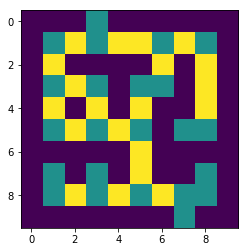

In [5]:
image = Image('./mazes/tiny.png') #yellow true
image.genOverlay()
image.displayOverlay()

listOrdinates = image.overlayPoints()
print('Essential points: {}\nTotal Points {}'.format(len(listOrdinates), image.rows* image.cols))


In [6]:
network = networkNodes(listOrdinates)
network.genDictNodes()

In [7]:
print('Initial point : (Linked point, distance between points)')
network.dictNodes

Initial point : (Linked point, distance between points)


{(0, 3): (((1, 3), 1),),
 (1, 1): (((1, 3), 2), ((3, 1), 2)),
 (1, 3): (((1, 6), 3), ((1, 1), 2), ((3, 3), 2), ((0, 3), 1)),
 (1, 6): (((1, 8), 2), ((1, 3), 3), ((3, 6), 2)),
 (1, 8): (((1, 6), 2), ((5, 8), 4)),
 (3, 1): (((3, 3), 2), ((5, 1), 2), ((1, 1), 2)),
 (3, 3): (((3, 5), 2), ((3, 1), 2), ((5, 3), 2), ((1, 3), 2)),
 (3, 5): (((3, 6), 1), ((3, 3), 2), ((5, 5), 2)),
 (3, 6): (((3, 5), 1), ((1, 6), 2)),
 (5, 1): (((5, 3), 2), ((7, 1), 2), ((3, 1), 2)),
 (5, 3): (((5, 5), 2), ((5, 1), 2), ((7, 3), 2), ((3, 3), 2)),
 (5, 5): (((5, 7), 2), ((5, 3), 2), ((8, 5), 3), ((3, 5), 2)),
 (5, 7): (((5, 8), 1), ((5, 5), 2), ((8, 7), 3)),
 (5, 8): (((5, 7), 1), ((7, 8), 2), ((1, 8), 4)),
 (7, 1): (((7, 3), 2), ((8, 1), 1), ((5, 1), 2)),
 (7, 3): (((7, 8), 5), ((7, 1), 2), ((8, 3), 1), ((5, 3), 2)),
 (7, 8): (((7, 3), 5), ((8, 8), 1), ((5, 8), 2)),
 (8, 1): (((8, 3), 2), ((7, 1), 1)),
 (8, 3): (((8, 5), 2), ((8, 1), 2), ((7, 3), 1)),
 (8, 5): (((8, 7), 2), ((8, 3), 2), ((5, 5), 3)),
 (8, 7): (((

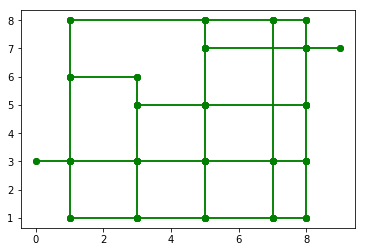

In [8]:
for original in network.dictNodes.keys():
    for points, distance in network.dictNodes[original]:
        plt.plot((original[0], points[0]), (original[1], points[1]), 'go-')